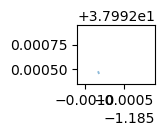

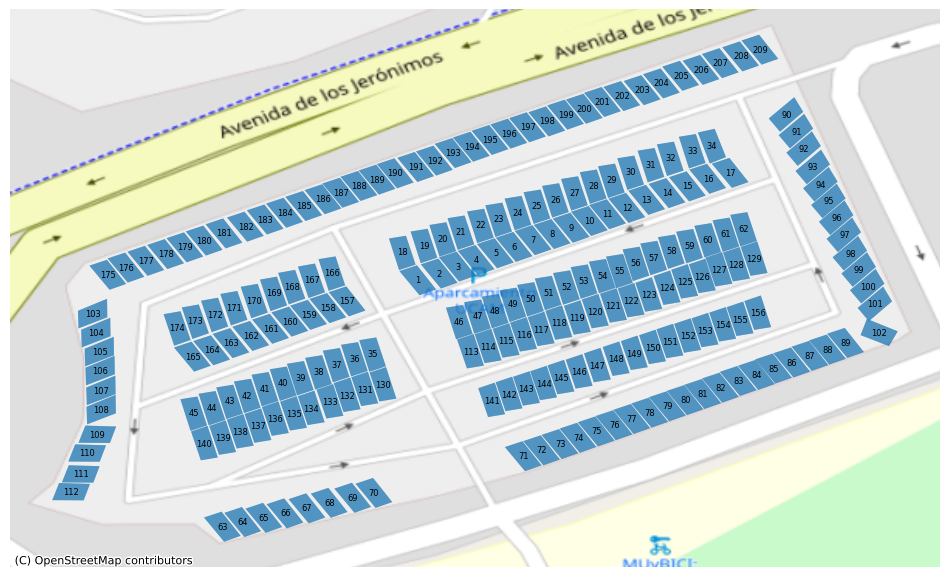

In [1]:
#LAYER 1. PARKING LOTS

import contextily as ctx
import pandas as pd
import pytz
import pandas as pd
import pytz
import pybdshadow
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


geo_df_1 = gpd.read_file('primary_parking_space.geojson')

geo_df_wm = geo_df_1.to_crs(epsg=4326)

# Set up the figure
ax = geo_df_wm.plot(figsize=(1,1), alpha=0.5, edgecolor='none')
# Set the map extent using the coordinates of the university parking
ax.set_xlim([-1.1861, -1.1851])
ax.set_ylim([37.99235, 37.99295])


geo_df_2 = gpd.read_file('/Users/masabosimplicefrank/wong-shadow/ucam_parking_all_spaces (1).geojson')

geo_df_wm = geo_df_2.to_crs(epsg=4326)

# Set up the figure
ax = geo_df_wm.plot(figsize=(12, 12), alpha=0.5, edgecolor='none')

# Load the GeoDataFrame from GeoJSON file
geo_df_2 = gpd.read_file('ucam_parking_all_spaces.geojson')

# Add a new column 'lot_id' to the GeoDataFrame and assign unique IDs to each lot
geo_df_2['lot_id'] = range(1, len(geo_df_2) + 1)


# Plot the GeoDataFrame
geo_df_2.plot(ax=ax, alpha=0.5, edgecolor='none')

# Annotate each lot with its ID
for idx, lot in geo_df_2.iterrows():
    # Get the centroid coordinates of the lot
    centroid_x, centroid_y = lot['geometry'].centroid.x, lot['geometry'].centroid.y

    # Annotate the lot with its ID
    ax.annotate(str(lot['lot_id']), (centroid_x, centroid_y), color='black', fontsize=6, ha='center', va='center')

# Add the basemap
ctx.add_basemap(ax, crs=geo_df_wm.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=19)

# Remove axis labels
ax.set_axis_off()    
# Set the plot title and labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()
        
geo_df_2.to_file("geo_df_1.geojson", driver="GeoJSON")



In [1]:
#LAYER 2. ROOFS

from keplergl import KeplerGl
import geopandas as gpd

# Step 2: Create a Kepler.gl map instance
map_1 = KeplerGl(height=600)

# Step 3: Add data to the map
geo_df = gpd.read_file('/Users/masabosimplicefrank/wong-shadow/ucam_parking_synth_roof.geojson')
geo_df['floor'] = 1
geo_df['height'] = 1
geo_df['x'] = geo_df['geometry'].apply(lambda g: g.centroid.x)
geo_df['y'] = geo_df['geometry'].apply(lambda g: g.centroid.y)
map_1.add_data(data=geo_df, name='geo_data')

# Step 4: Visualize and interact
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'geo_data': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'columns': ['geometry', 'floor', 'height'…

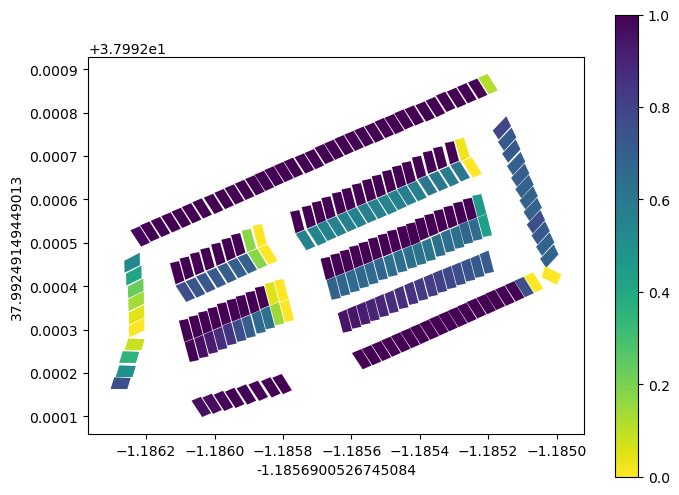

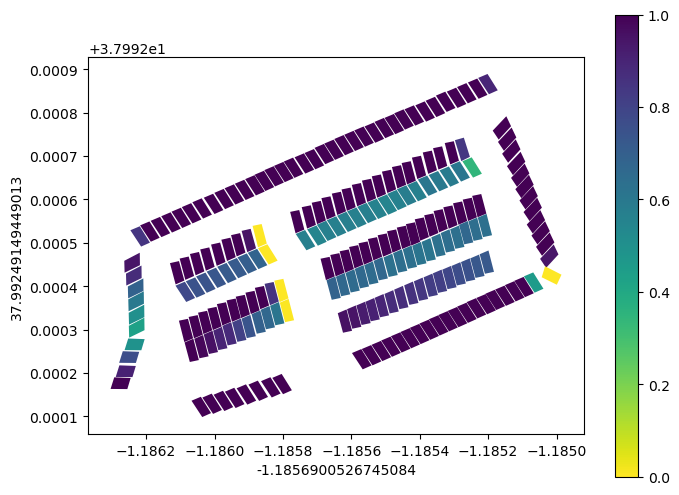

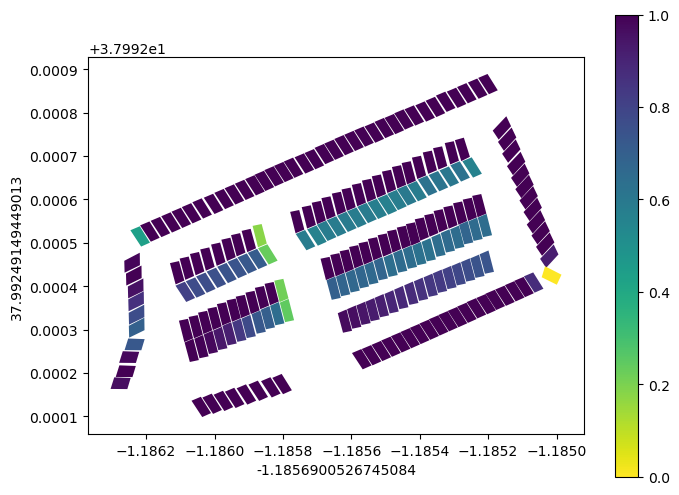

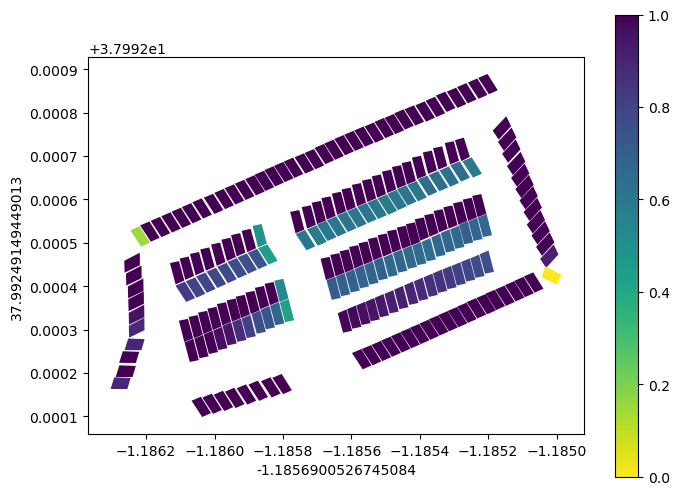

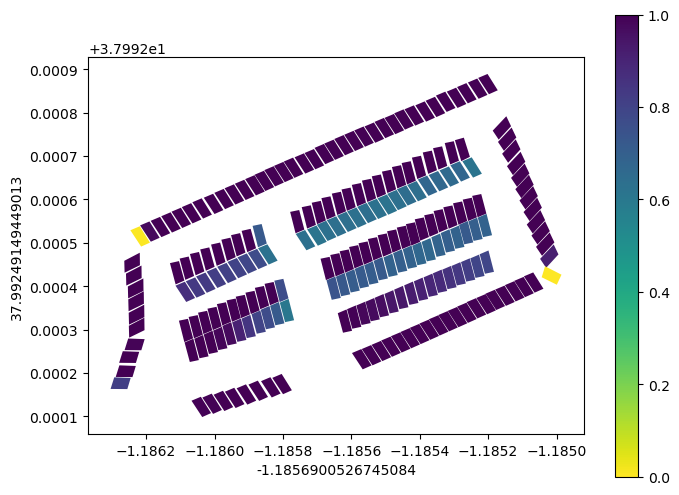

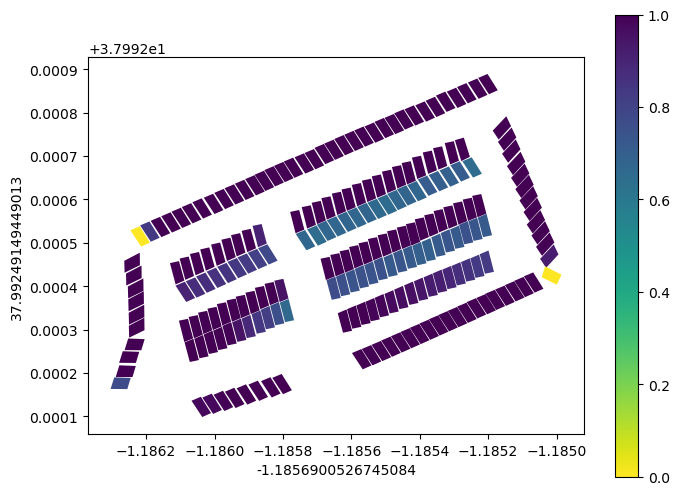

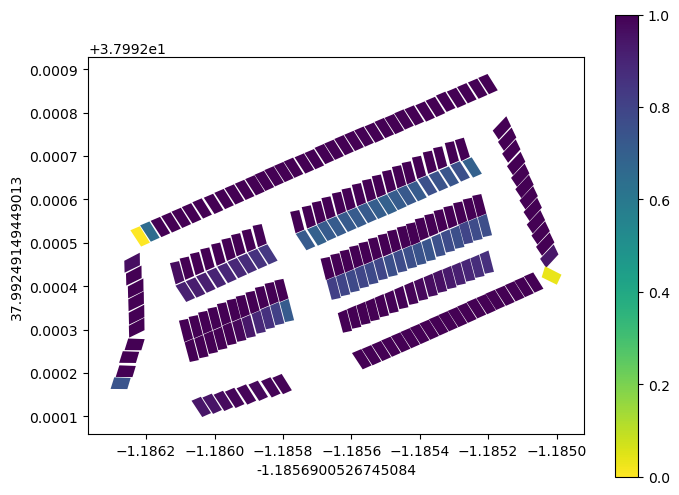

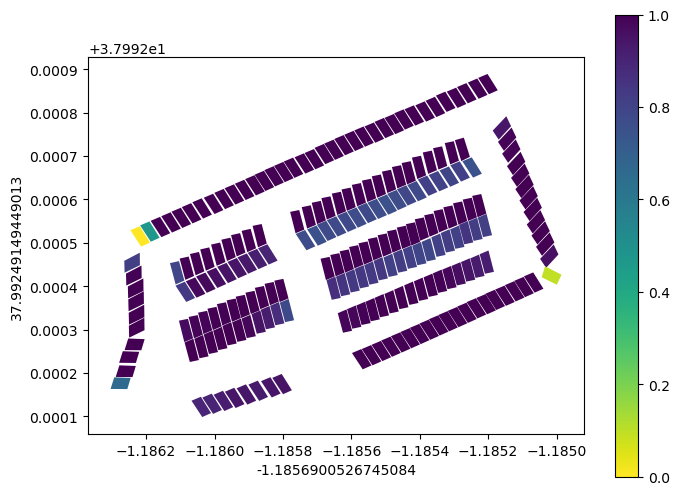

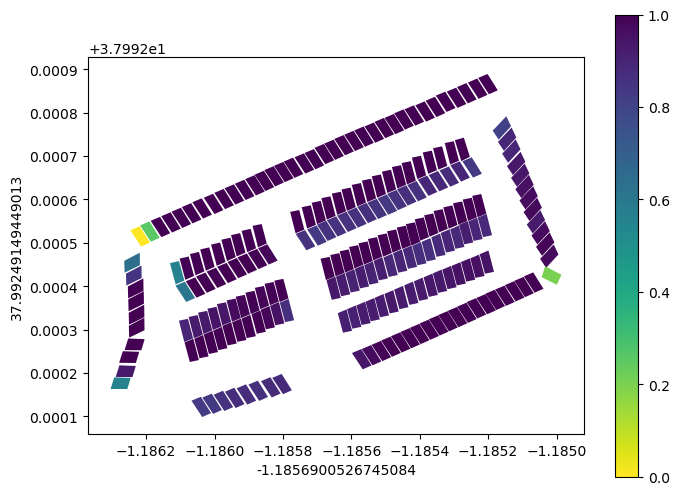

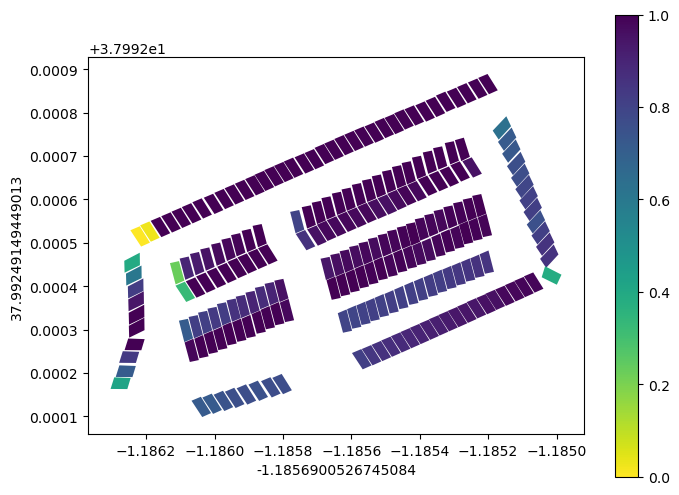

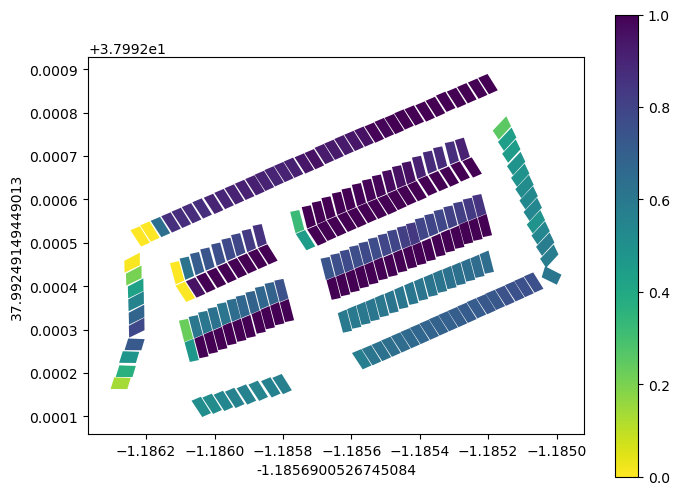

interactive(children=(IntSlider(value=0, description='Hour:', max=10), Output()), _dom_classes=('widget-intera…

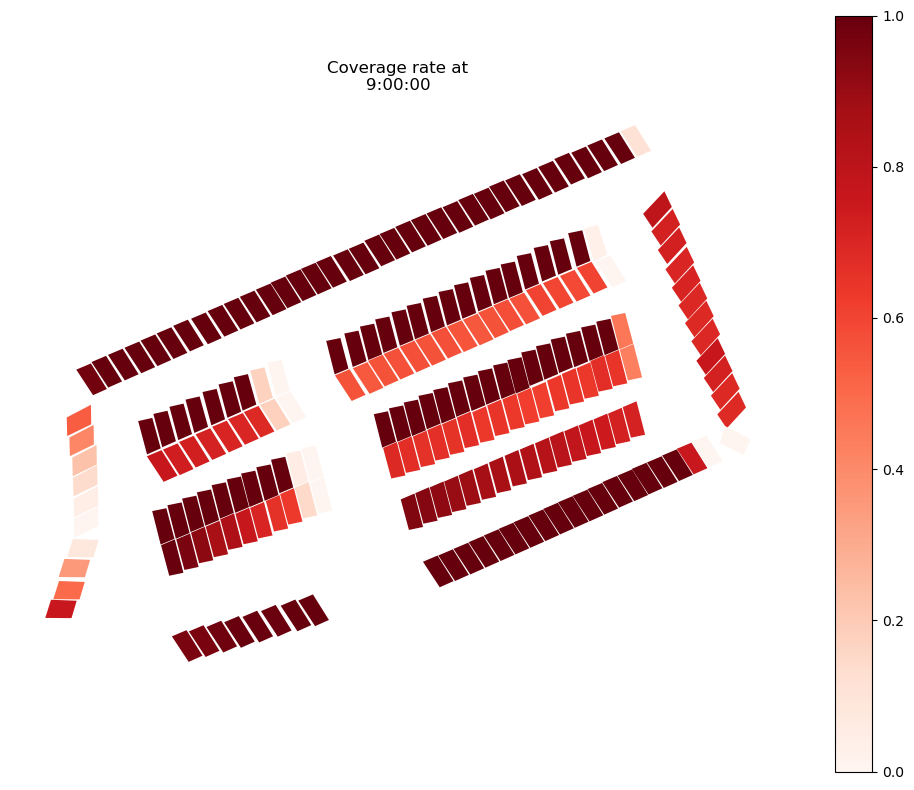

In [7]:
#LAYER 3. COVERAGE

import pandas as pd
import pybdshadow
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import math
import contextily as ctx

from datetime import datetime, timedelta

from suncalc import get_position
from shapely.geometry import Polygon
import pytz

import warnings
warnings.filterwarnings('ignore')

# Define function to calculate shadow and sunlight for a single rooftop
def sunshadeshadow_sunlight(date, r, sunshade_height=2):
    meanlon= r.centroid.x
    meanlat= r.centroid.y
    # obtain sun position
    sunPosition = get_position(date, meanlon, meanlat)
    if sunPosition['altitude'] < 0:
        raise ValueError("Given time before sunrise or after sunset")
    r_coords= np.array(r.exterior.coords)
    r_coords= r_coords.reshape(1,-1,2)
    shape = pybdshadow.utils.lonlat2aeqd(r_coords,meanlon,meanlat)
    azimuth = sunPosition['azimuth']
    altitude = sunPosition['altitude']

    n = np.shape(shape)[0]
    distance = sunshade_height / math.tan(altitude)

    # calculate the offset of the projection position
    lonDistance = distance * math.sin(azimuth)
    latDistance = distance * math.cos(azimuth)

    shadowShape = np.zeros((1, 5, 2))
    shadowShape[:, :, :] += shape
    shadowShape[:, :, 0] = shape[:, :, 0] + lonDistance
    shadowShape[:, :, 1] = shape[:, :, 1] + latDistance
    shadowShape = pybdshadow.utils.aeqd2lonlat(shadowShape,meanlon,meanlat)
    p = Polygon([[p[0], p[1]] for p in shadowShape[0]])
    return p

# Define function to calculate shadow and sunlight for all rooftops
def all_sunshadeshadow_sunlight(date, roof_df, roofs=2):
    roof_projected_df= roof_df.copy()
    roof_projected_df['geometry'] = roof_projected_df.apply(lambda r: sunshadeshadow_sunlight(date, r[0]), axis=1)
    return roof_projected_df

# Load GeoDataFrame with rooftop geometries
geo_df = gpd.read_file('ucam_parking_synth_roof.geojson')

# Define the date and city
date_str = '2023-06-15 16:00:00'
city = 'Europe/Madrid'
timezone = pytz.timezone(city)
date = pd.to_datetime(date_str).tz_localize('UTC').tz_convert(timezone)

# Compute shadows and sunlight for all rooftops
geo_projected_df = all_sunshadeshadow_sunlight(date, geo_df)

# Plot the result
#geo_projected_df.plot()

# Define the date range for analysis
date_str = '2022-07-15 07:00:00'
city = 'Europe/Madrid'
timezone = pytz.timezone(city)
date = pd.to_datetime(date_str).tz_localize('UTC').tz_convert(timezone)
end_date = date + pd.DateOffset(hours=10)
date_range = pd.date_range(start=date, end=end_date, freq='H')

# Create a DataFrame with date and time values
df = pd.DataFrame({'datetime': date_range})
df['datetime'] = df['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S %Z%z')

# Save the DataFrame to a CSV file
df.to_csv('data.csv', index=False)

# Load the parking space GeoDataFrame
geo_df_2 = gpd.read_file('ucam_parking_all_spaces.geojson')
geo_df_2 = geo_df_2.set_crs(epsg=4326)

# Loop through each hour and compute coverage rates
for i in range(len(date_range)):
    current_date = date_range[i]
    shadows = all_sunshadeshadow_sunlight(current_date, geo_df)

    # Calculate coverage rates...
    shadows_crs = "EPSG:4326"  # Change this to the appropriate CRS if it's different
    shadows.crs = shadows_crs

    coverage_rates = []

    for index, parking_space in geo_df_2.iterrows():
        parking_space_gdf = gpd.GeoDataFrame(geometry=[parking_space.geometry])
        parking_space_gdf = parking_space_gdf.set_crs(crs=shadows_crs)
        parking_space_gdf = parking_space_gdf.to_crs(epsg=shadows.crs.to_epsg())

        intersection = gpd.overlay(parking_space_gdf, shadows, how='intersection')
        intersection.crs = shadows.crs

        intersection_area = intersection.geometry.area.sum()
        parking_space_area = parking_space_gdf.geometry.area.sum()

        coverage_rate = intersection_area / parking_space_area

        coverage_rates.append(coverage_rate)

    geo_df_2[f'coverage_rate_{current_date.strftime("%H:%M:%S")}'] = coverage_rates

    # Plot the GeoDataFrame with coverage rates
    fig, ax = plt.subplots(figsize=(8, 6))

    geo_df_2.plot(column=f'coverage_rate_{current_date.strftime("%H:%M:%S")}',
      cmap='viridis_r',
      legend=True,
      ax=ax,
      edgecolor='none')

    plt.xlabel('-1.1856900526745084')
    plt.ylabel('37.99249149449013')



    # Save GeoDataFrame to a Shapefile
    geo_df_2.to_file(f"geo_df_3.geojson", driver="GeoJSON")
    
   #..................................... 
    
    
!pip install pillow

import contextily as ctx
import pandas as pd
import pytz
import pybdshadow
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
from PIL import Image
import glob
import ipywidgets as widgets
from IPython.display import display

warnings.filterwarnings('ignore')

geo_df_3 = gpd.read_file('geo_df_3.geojson')

# Get the column names except the last one
columns_to_rename = geo_df_3.columns[:-1]

# Create a list of time strings starting from 09:00:00
time_strings = [f'{hour}:00:00' for hour in range(9, 20)]

# Create a dictionary to map old column names to new time strings
new_column_names = {old_name: new_name for old_name, new_name in zip(columns_to_rename, time_strings)}

# Rename the columns
geo_df_3.rename(columns=new_column_names, inplace=True)

hours = [column for column in geo_df_3.columns[:-1]]  # Exclude the last column
vmin, vmax = 0, 1

# Function to update plot based on slider value
def update_plot(hour_index):
    hour = hours[hour_index]
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    map = geo_df_3.plot(ax=ax, column=hour, cmap='Reds', linewidth=0.5,
                        vmin=vmin, vmax=vmax, legend=True,
                        norm=plt.Normalize(vmin=vmin, vmax=vmax))
    map.set_title("Coverage rate at\n" + hour)
    plt.axis('off')  # Turn off axis
    plt.tight_layout()  # Adjust layout

# Create slider widget
slider = widgets.IntSlider(min=0, max=len(hours) - 1, value=0, description='Hour:')
widgets.interact(update_plot, hour_index=slider)

# Show the plot initially
update_plot(0)
plt.show()



interactive(children=(IntSlider(value=0, description='Hour:', max=10), Output()), _dom_classes=('widget-intera…

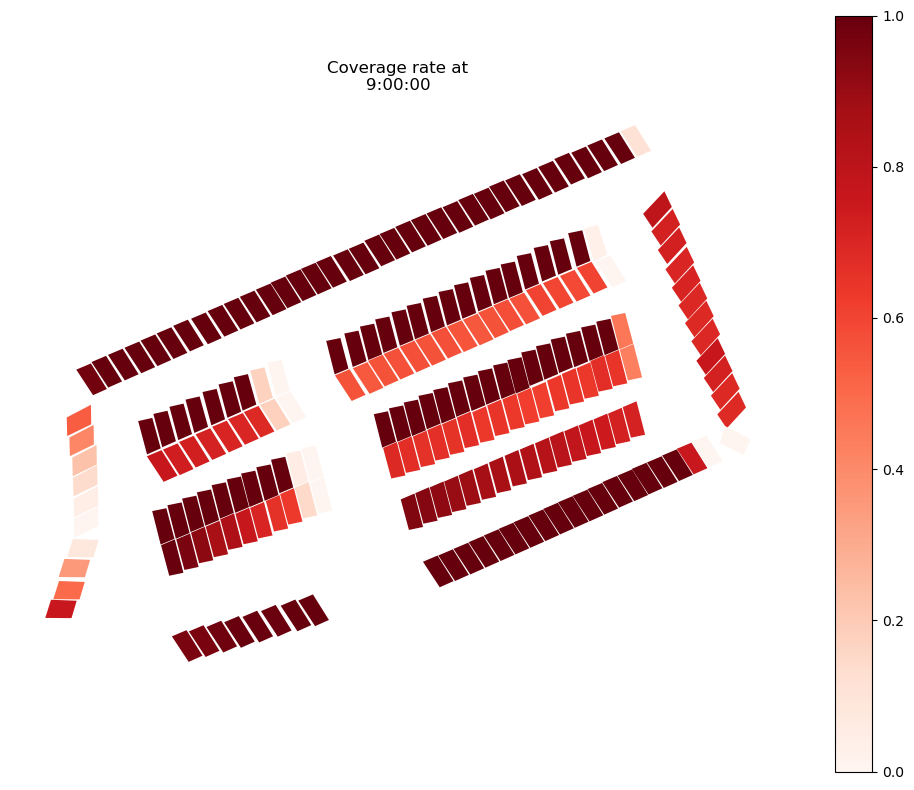

In [4]:
!pip install pillow

import contextily as ctx
import pandas as pd
import pytz
import pybdshadow
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
from PIL import Image
import glob
import ipywidgets as widgets
from IPython.display import display

warnings.filterwarnings('ignore')

geo_df_3 = gpd.read_file('geo_df_3.geojson')

# Get the column names except the last one
columns_to_rename = geo_df_3.columns[:-1]

# Create a list of time strings starting from 09:00:00
time_strings = [f'{hour}:00:00' for hour in range(9, 20)]

# Create a dictionary to map old column names to new time strings
new_column_names = {old_name: new_name for old_name, new_name in zip(columns_to_rename, time_strings)}

# Rename the columns
geo_df_3.rename(columns=new_column_names, inplace=True)

hours = [column for column in geo_df_3.columns[:-1]]  # Exclude the last column
vmin, vmax = 0, 1

# Function to update plot based on slider value
def update_plot(hour_index):
    hour = hours[hour_index]
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    map = geo_df_3.plot(ax=ax, column=hour, cmap='Reds', linewidth=0.5,
                        vmin=vmin, vmax=vmax, legend=True,
                        norm=plt.Normalize(vmin=vmin, vmax=vmax))
    map.set_title("Coverage rate at\n" + hour)
    plt.axis('off')  # Turn off axis
    plt.tight_layout()  # Adjust layout

# Create slider widget
slider = widgets.IntSlider(min=0, max=len(hours) - 1, value=0, description='Hour:')
widgets.interact(update_plot, hour_index=slider)

# Show the plot initially
update_plot(0)
plt.show()


Name   ::  Test Stat > C(95%)    =>   Signif
 ----------------------------------------
Farcas_cabin_temp :: 14.97 > 12.3212 => True
Temperature (°C) :: 0.0 > 4.1296 => False
Augmented Dickey-Fuller Test on "Farcas_cabin_temp"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level    = 0.05
Test Statistic        = -4.7483815970612335
No. Lags Chosen       = 1
Critical value 1%     = -3.46
Critical value 5%     = -2.875
Critical value 10%    = -2.574
P-Value = 6.819866461287023e-05. Rejecting Null Hypothesis. Series is Stationary.


Augmented Dickey-Fuller Test on "Temperature (°C)"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level    = 0.05
Test Statistic        = -1.528986826261586
No. Lags Chosen       = 9
Critical value 1%     = -3.461
Critical value 5%     = -2.875
Critical value 10%    = -2.574
P-Value = 0.5191263640264822. Weak evidence to reject t

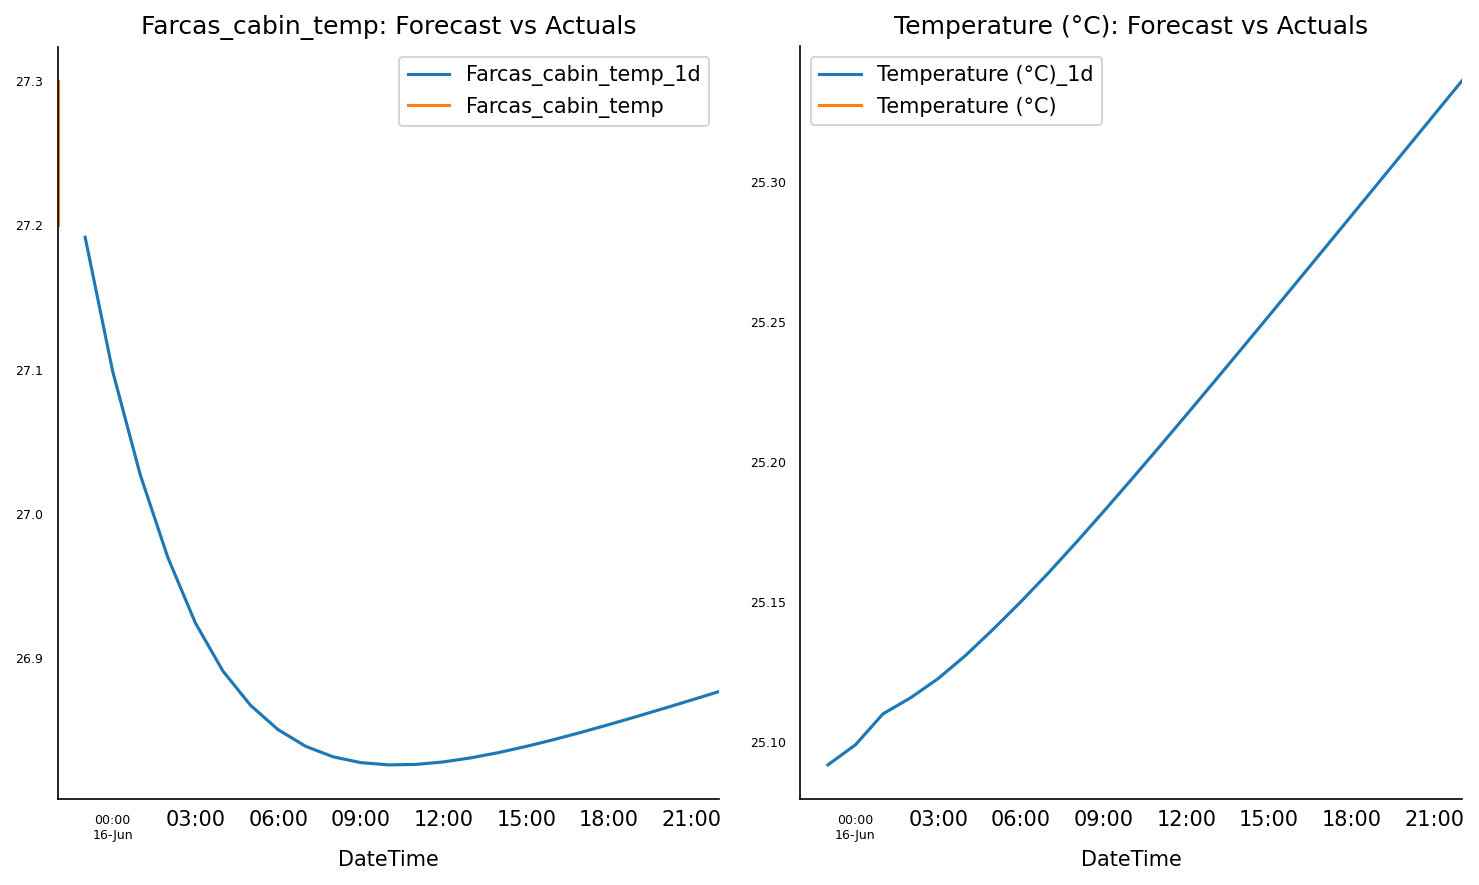

Coefficients: 
 [ 0.22186813  1.         -7.20769231]


In [5]:
#LAYER4. AMBIENT AND CABIN TEMPERATURE PREDUCTION WITH VAR
        
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings('ignore')



# Import and anylise the dataset of recorded cabin temperatures

Farcas_data = pd.read_excel("Farcas_data.xlsx")


# Rename the column 'old_column_name' to 'new_column_name'
Farcas_data = Farcas_data.rename(columns={'Temperature°C': 'Farcas_cabin_temp'})


# Retrieve and analysing weather data in Murcia Spain.
#Source:open-meteo.com/en/docs/historical-weather-api#latitude=37.987&longitude=-1.13

his_temp = pd.read_excel("historical_weather_data_MU.xlsx") #Use date and city input interface

his_temp

#Target data
#Reset index to make 'DateTime' a column
Farcas_data.reset_index(inplace=True)
# Select data for a specific day, for example, '2023-06-15 00:00:00' to '2023-06-15 23:00:00'
target_data_1= Farcas_data[(Farcas_data['DateTime'] >= '2023-06-15 00:00:00') & (Farcas_data['DateTime'] <= '2023-06-15 23:00:00')]

target_data_1['DateTime'] = pd.to_datetime(target_data_1['DateTime'])
target_data_1.set_index('DateTime', inplace=True)

# Reset minutes and seconds to zero for each hour
target_data_1.index = target_data_1.index.floor('H')

#target_data_1

# Drop the specified columns
target_data_1 = target_data_1.drop(columns=['index', 'No.'])



#Reset index to make 'DateTime' a column
his_temp.reset_index(inplace=True)
# Select data for a specific day, for example, '2023-06-15 00:00:00' to '2023-06-15 23:00:00'
target_data_2= his_temp[(his_temp['DateTime'] >= '2023-06-15 00:00:00') & (his_temp['DateTime'] <= '2023-06-15 23:00:00')]
#target_data=all_data[['Farcas_cabin_temp','Temperature (°C)','App_temper (°C)','Windspeed (km/h)']]
target_data_2

target_data_2['DateTime'] = pd.to_datetime(target_data_2['DateTime'])
target_data_2.set_index('DateTime', inplace=True)
target_data_2

# Drop the specified columns
target_data_2 = target_data_2.drop(columns=['index', 'App_temper (°C)','Rain (mm)','Windspeed (km/h)'])



target_data = pd.merge(target_data_1, target_data_2, on='DateTime', how='inner')

# Print the merged DataFrame
target_data

all_data= target_data[['Farcas_cabin_temp', 'Temperature (°C)']]
all_data


# TEMPERATURE PREDUCTOR USING VAR



all_data= target_data[['Farcas_cabin_temp', 'Temperature (°C)']]

# Function to test Granger causality between variables
def grangers_causation_matrix(data, variables):
    maxlag = 12
    all_data = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in all_data.columns:
        for r in all_data.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0]['ssr_chi2test'][1], 4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            all_data.loc[r, c] = min_p_value

    all_data.columns = [var + '_x' for var in variables]
    all_data.index = [var + '_y' for var in variables]
    return all_data

# Test Granger causality
grangers_matrix = grangers_causation_matrix(all_data, variables=all_data.columns)

# Function to perform cointegration test
def cointegration_test(data, alpha=0.05):
    out = coint_johansen(data, -1, 5)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    print('Name   ::  Test Stat > C(95%)    =>   Signif\n', '--'*20)
    for col, trace, cvt in zip(data.columns, traces, cvts):
        print(f'{col.ljust(6)} :: {round(trace, 2)} > {round(cvt, 8)} => {trace > cvt}')

# Perform cointegration test
cointegration_test(all_data)


# Split the Series into Training and Testing Data
nobs = 4
target_data_train, target_data_test = all_data[0:-nobs], all_data[-nobs:]

# Function to check for stationarity using ADFuller test
def adfuller_test(series, signif=0.05, name='', verbose=False):
    result = adfuller(series, autolag='AIC')
    p_value = result[1]

    print(f'Augmented Dickey-Fuller Test on "{name}"\n{"-"*47}')
    print(f'Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f'Significance Level    = {signif}')
    print(f'Test Statistic        = {result[0]}')
    print(f'No. Lags Chosen       = {result[2]}')

    for key, val in result[4].items():
        print(f'Critical value {key.ljust(6)} = {round(val, 3)}')

    if p_value <= signif:
        print(f'P-Value = {p_value}. Rejecting Null Hypothesis. Series is Stationary.')
    else:
        print(f'P-Value = {p_value}. Weak evidence to reject the Null Hypothesis. Series is Non-Stationary.')

# Check for stationarity and make the time series stationary
target_data_differenced = target_data_train.diff().dropna()

# Apply ADFuller test for stationarity
for name, column in target_data_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

# Fit VAR model with different lag orders and print AIC, BIC, FPE, and HQIC
for lag_order in [1, 2, 3, 4, 5]:
    model = VAR(target_data_differenced)
    result = model.fit(lag_order)

    print(f'Lag Order = {lag_order}\nAIC : {result.aic}\nBIC : {result.bic}\nFPE : {result.fpe}\nHQIC: {result.hqic}\n')

# Train the VAR model with selected lag order
model_fitted = model.fit(5)
print(model_fitted.summary())

# Check for serial correlation of residuals using Durbin-Watson test
dw_stats = durbin_watson(model_fitted.resid)
for col, val in zip(target_data.columns, dw_stats):
    print(f'{col.ljust(25)}: {round(val, 2)}')

# Forecast VAR model using statsmodels
lag_order = model_fitted.k_ar
forecast_input = target_data_differenced.values[-lag_order:]
forecast_steps = 24  # Assuming one day with hourly data
model = VAR(target_data_differenced)
model_fitted = model.fit(5)  # Assuming lag order of 9, adjust as needed
fc = model_fitted.forecast(y=forecast_input, steps=forecast_steps)
forecast_index = pd.date_range(start=target_data.index[-1] + pd.Timedelta(hours=1), periods=forecast_steps, freq='H')
target_data_forecast = pd.DataFrame(fc, index=forecast_index, columns=[f'{col}_1d' for col in target_data.columns])

# Invert the transformation to get the real forecast
def invert_transformation(train_data, forecast_data):
    forecast_result = forecast_data.copy()
    columns = train_data.columns

    for col in columns:
        forecast_result[f'{col}_1d'] = train_data[col].iloc[-1] + forecast_result[f'{col}_1d'].cumsum()

    return forecast_result

# Display the inverted forecast results
target_data_results = invert_transformation(target_data_train, target_data_forecast)
print(target_data_results.loc[:, ['Farcas_cabin_temp_1d','Temperature (°C)_1d']])

# Plot forecast vs actuals
fig, axes = plt.subplots(nrows=int(len(target_data.columns)/2), ncols=2, dpi=150, figsize=(10, 6))

for i, (col, ax) in enumerate(zip(target_data.columns, axes.flatten())):
    target_data_results[col+'_1d'].plot(legend=True, ax=ax).autoscale(axis='x', tight=True)
    target_data_test[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(f'{col}: Forecast vs Actuals')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.spines["right"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()
plt.show()


# PREDICTED CABIN TEMPERATURES (covered and uncovered vehicles)

# In[56]:


from sklearn.linear_model import LinearRegression

def generate_cabin_temp_dataset():
    data_no_roof = pd.read_csv('cabin_temperature_no_roof.csv')
    data_no_roof['coverage']=0
    data_roof = pd.read_csv('cabin_temperature_w_roof.csv')
    data_roof['coverage']=1

    temp_data = pd.concat([data_no_roof, data_roof], axis=0)

    fake_dfs = []
    for diff in [10,15,20]:
        fake_temp_data= temp_data.copy()

        fake_temp_data['temp_ext']= fake_temp_data['temp_ext']-diff
        fake_temp_data['temp_int']= fake_temp_data['temp_int']-diff

        fake_dfs.append(fake_temp_data)

    fake_data = pd.concat(fake_dfs, axis=0)
    temp_data= pd.concat([temp_data, fake_data])
    temp_data= temp_data.reset_index(drop=True)

    X= temp_data['T temp_ext coverage'.split()].values
    y=  temp_data['temp_int'].values

    return X, y


def generate_cabin_temp_predictor():
    X, y= generate_cabin_temp_dataset()
    clf = LinearRegression().fit(X, y)
    return clf

temp_predictor= generate_cabin_temp_predictor()
print("Coefficients: \n", temp_predictor.coef_)



#Predicted cabin temperature_no_roof


df1=target_data_results.loc[:, ['Farcas_cabin_temp_1d']]
df1.rename(columns={'Farcas_cabin_temp_1d': 'Farcas_cabin_temp_no_roof'}, inplace=True)
df1


# In[57]:


#Find the differences between the predicted cabin temp without roof and predicted cabin temp with roof

r=0.22186813 #coverage rate
df2=df1*r
df2.rename(columns={'Farcas_cabin_temp_no_roof': 'temp_diff'}, inplace=True)
df2


# In[59]:


#predicted cabin temperatures_with-roof

df3=pd.concat([df1, df2], axis=1)
df3['Farcas_cabin_temp_w_roof'] = df3['Farcas_cabin_temp_no_roof'] - df3['temp_diff']
df3

#Predicted regional temperature
df4=target_data_results.loc[:, ['Temperature (°C)_1d']]
df4

#Combining predicted cabin temperatures in one teble

df5=pd.concat([df3, df4], axis=1)
df5

# Save DataFrame to a CSV file
df5.to_csv("Temp_data.csv", index=False)  # Set index=False to avoid saving row indices

        

Name   ::  Test Stat > C(95%)    =>   Signif
 ----------------------------------------
Farcas_cabin_temp :: 14.97 > 12.3212 => True
Temperature (°C) :: 0.0 > 4.1296 => False
Augmented Dickey-Fuller Test on "Farcas_cabin_temp"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level    = 0.05
Test Statistic        = -4.7483815970612335
No. Lags Chosen       = 1
Critical value 1%     = -3.46
Critical value 5%     = -2.875
Critical value 10%    = -2.574
P-Value = 6.819866461287023e-05. Rejecting Null Hypothesis. Series is Stationary.
Augmented Dickey-Fuller Test on "Temperature (°C)"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level    = 0.05
Test Statistic        = -1.528986826261586
No. Lags Chosen       = 9
Critical value 1%     = -3.461
Critical value 5%     = -2.875
Critical value 10%    = -2.574
P-Value = 0.5191263640264822. Weak evidence to reject the

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


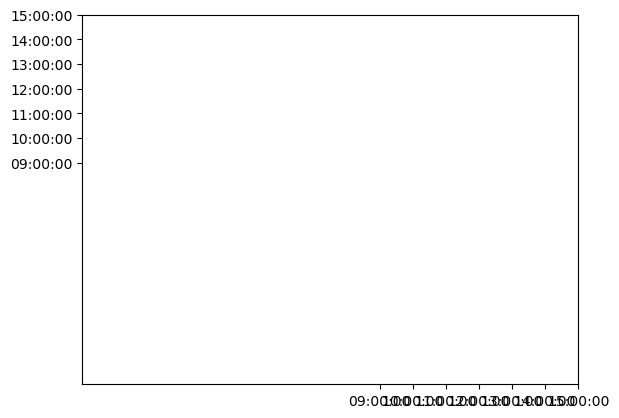

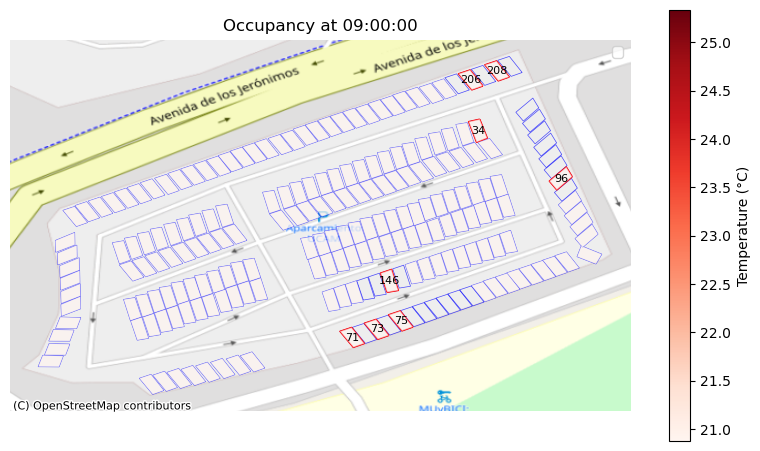

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


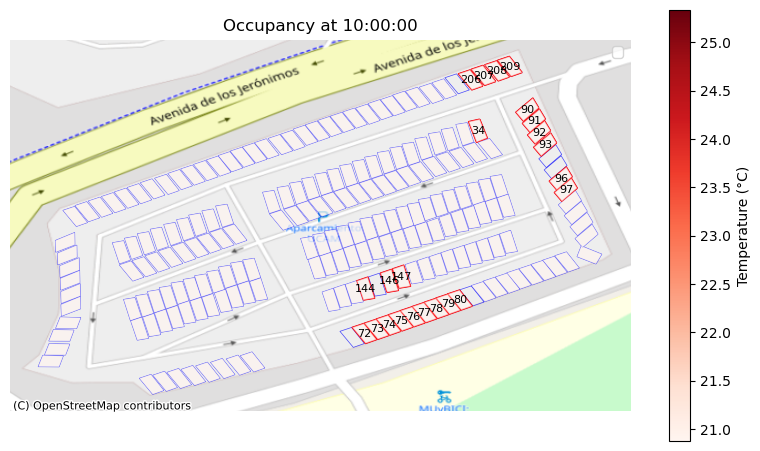

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


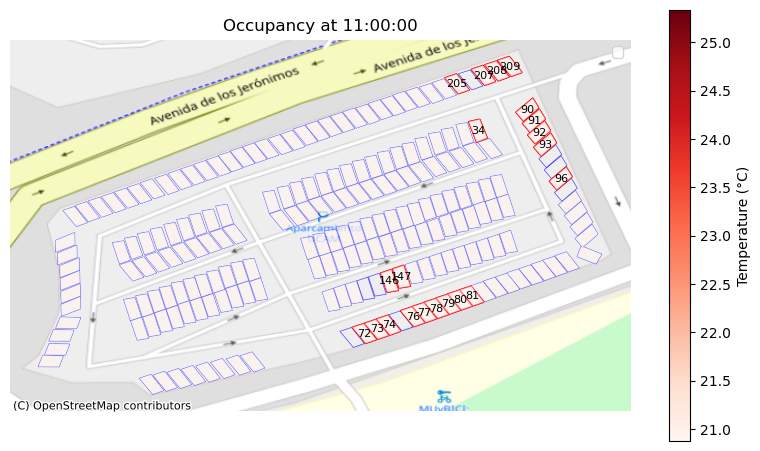

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


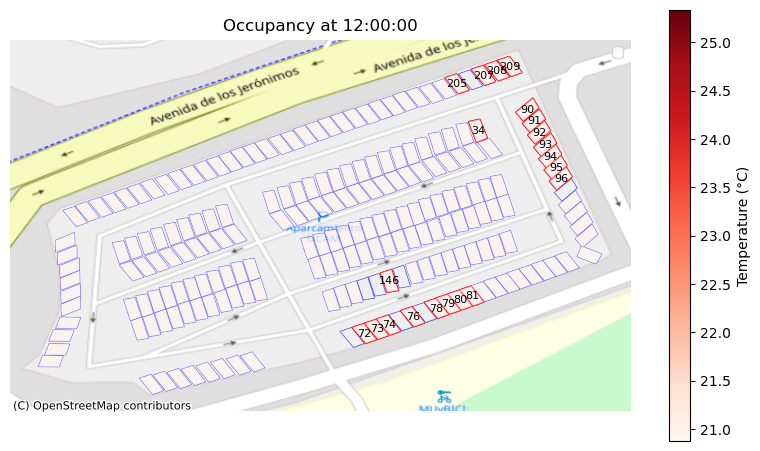

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


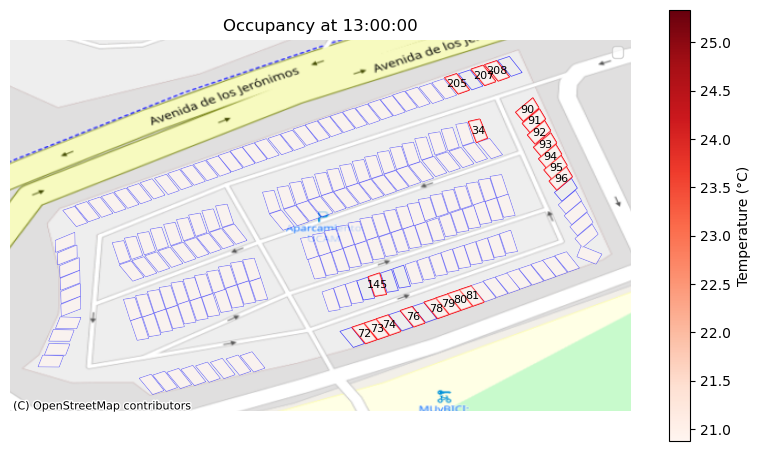

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


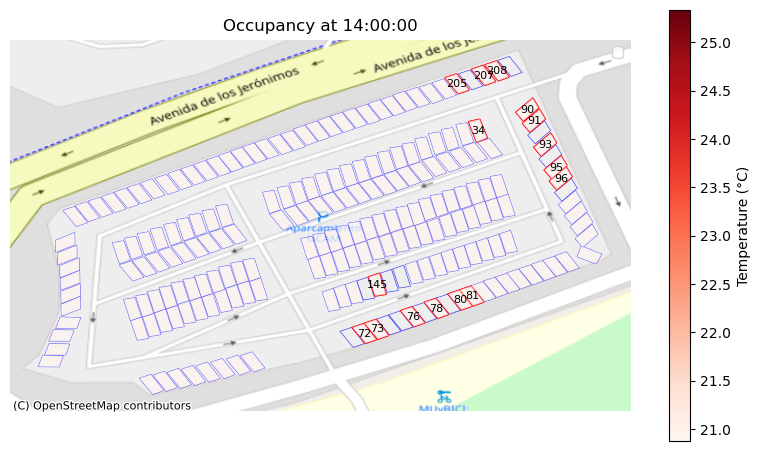

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


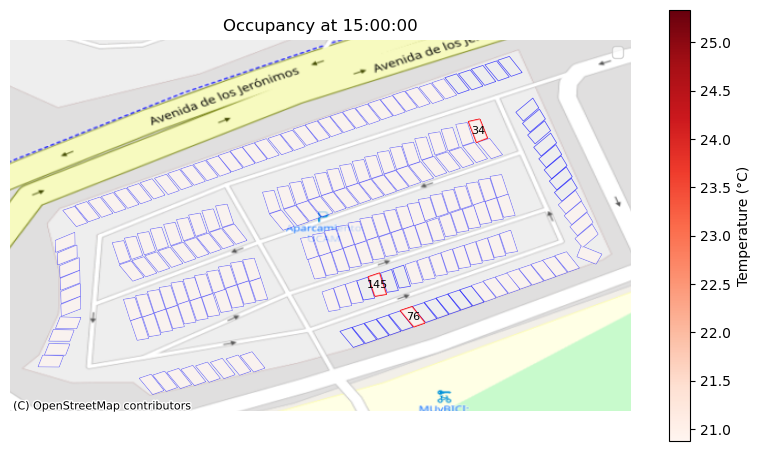

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


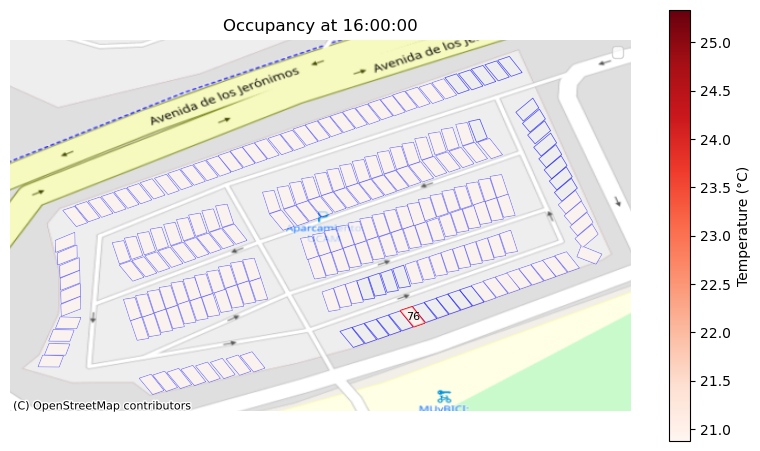

In [6]:
#LAYER 5. LOTS OCCUPANCY STATUS-COVERED
        
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from shapely.geometry import Point
import contextily as ctx
import warnings
warnings.filterwarnings('ignore')

# Import and analyze the dataset of recorded cabin temperatures
Farcas_data = pd.read_excel("Farcas_data.xlsx")

# Rename the column 'old_column_name' to 'new_column_name'
Farcas_data = Farcas_data.rename(columns={'Temperature°C': 'Farcas_cabin_temp'})

# Retrieve and analyze weather data in Murcia Spain.
# Source: open-meteo.com/en/docs/historical-weather-api#latitude=37.987&longitude=-1.13
his_temp = pd.read_excel("historical_weather_data_MU.xlsx")  # Use date and city input interface

# Target data
# Reset index to make 'DateTime' a column
Farcas_data.reset_index(inplace=True)
# Select data for a specific day, for example, '2023-06-15 00:00:00' to '2023-06-15 23:00:00'
target_data_1 = Farcas_data[(Farcas_data['DateTime'] >= '2023-06-15 00:00:00') & (Farcas_data['DateTime'] <= '2023-06-15 23:00:00')]
target_data_1['DateTime'] = pd.to_datetime(target_data_1['DateTime'])
target_data_1.set_index('DateTime', inplace=True)

# Reset minutes and seconds to zero for each hour
target_data_1.index = target_data_1.index.floor('H')

# Drop the specified columns
target_data_1 = target_data_1.drop(columns=['index', 'No.'])

# Reset index to make 'DateTime' a column
his_temp.reset_index(inplace=True)
# Select data for a specific day, for example, '2023-06-15 00:00:00' to '2023-06-15 23:00:00'
target_data_2 = his_temp[(his_temp['DateTime'] >= '2023-06-15 00:00:00') & (his_temp['DateTime'] <= '2023-06-15 23:00:00')]
target_data_2['DateTime'] = pd.to_datetime(target_data_2['DateTime'])
target_data_2.set_index('DateTime', inplace=True)

# Drop the specified columns
target_data_2 = target_data_2.drop(columns=['index', 'App_temper (°C)','Rain (mm)','Windspeed (km/h)'])

target_data = pd.merge(target_data_1, target_data_2, on='DateTime', how='inner')

# Print the merged DataFrame
#print(target_data)

all_data = target_data[['Farcas_cabin_temp', 'Temperature (°C)']]
all_data

# TEMPERATURE PREDICTOR USING VAR
# Function to test Granger causality between variables
def grangers_causation_matrix(data, variables):
    maxlag = 12
    all_data = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in all_data.columns:
        for r in all_data.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0]['ssr_chi2test'][1], 4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            all_data.loc[r, c] = min_p_value

    all_data.columns = [var + '_x' for var in variables]
    all_data.index = [var + '_y' for var in variables]
    return all_data

# Test Granger causality
grangers_matrix = grangers_causation_matrix(all_data, variables=all_data.columns)

# Function to perform cointegration test
def cointegration_test(data, alpha=0.05):
    out = coint_johansen(data, -1, 5)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    print('Name   ::  Test Stat > C(95%)    =>   Signif\n', '--'*20)
    for col, trace, cvt in zip(data.columns, traces, cvts):
        print(f'{col.ljust(6)} :: {round(trace, 2)} > {round(cvt, 8)} => {trace > cvt}')

# Perform cointegration test
cointegration_test(all_data)

# Split the Series into Training and Testing Data
nobs = 4
target_data_train, target_data_test = all_data[0:-nobs], all_data[-nobs:]

# Function to check for stationarity using ADFuller test
def adfuller_test(series, signif=0.05, name='', verbose=False):
    result = adfuller(series, autolag='AIC')
    p_value = result[1]

    print(f'Augmented Dickey-Fuller Test on "{name}"\n{"-"*47}')
    print(f'Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f'Significance Level    = {signif}')
    print(f'Test Statistic        = {result[0]}')
    print(f'No. Lags Chosen       = {result[2]}')

    for key, val in result[4].items():
        print(f'Critical value {key.ljust(6)} = {round(val, 3)}')

    if p_value <= signif:
        print(f'P-Value = {p_value}. Rejecting Null Hypothesis. Series is Stationary.')
    else:
        print(f'P-Value = {p_value}. Weak evidence to reject the Null Hypothesis. Series is Non-Stationary.')

# Check for stationarity and make the time series stationary
target_data_differenced = target_data_train.diff().dropna()

# Apply ADFuller test for stationarity
for name, column in target_data_differenced.iteritems():
    adfuller_test(column, name=column.name)

# Fit VAR model with different lag orders and print AIC, BIC, FPE, and HQIC
for lag_order in [1, 2, 3, 4, 5]:
    model = VAR(target_data_differenced)
    result = model.fit(lag_order)

# Train the VAR model with selected lag order
model_fitted = model.fit(5)
#print(model_fitted.summary())

# Check for serial correlation of residuals using Durbin-Watson test
dw_stats = durbin_watson(model_fitted.resid)
for col, val in zip(target_data.columns, dw_stats):
    print(f'{col.ljust(25)}: {round(val, 2)}')

# Forecast VAR model using statsmodels
lag_order = model_fitted.k_ar
forecast_input = target_data_differenced.values[-lag_order:]
forecast_steps = 24  # Assuming one day with hourly data
model = VAR(target_data_differenced)
model_fitted = model.fit(5)  # Assuming lag order of 9, adjust as needed
fc = model_fitted.forecast(y=forecast_input, steps=forecast_steps)
forecast_index = pd.date_range(start=target_data.index[-1] + pd.Timedelta(hours=1), periods=forecast_steps, freq='H')
target_data_forecast = pd.DataFrame(fc, index=forecast_index, columns=[f'{col}_1d' for col in target_data.columns])

# Invert the transformation to get the real forecast
def invert_transformation(train_data, forecast_data):
    forecast_result = forecast_data.copy()
    columns = train_data.columns

    for col in columns:
        forecast_result[f'{col}_1d'] = train_data[col].iloc[-1] + forecast_result[f'{col}_1d'].cumsum()

    return forecast_result

# Display the inverted forecast results
target_data_results = invert_transformation(target_data_train, target_data_forecast)


# PREDICTED CABIN TEMPERATURES (covered and uncovered vehicles)
from sklearn.linear_model import LinearRegression

def generate_cabin_temp_dataset():
    data_no_roof = pd.read_csv('cabin_temperature_no_roof.csv')
    data_no_roof['coverage']=0
    data_roof = pd.read_csv('cabin_temperature_w_roof.csv')
    data_roof['coverage']=1

    temp_data = pd.concat([data_no_roof, data_roof], axis=0)

    fake_dfs = []
    for diff in [10,15,20]:
        fake_temp_data= temp_data.copy()

        fake_temp_data['temp_ext']= fake_temp_data['temp_ext']-diff
        fake_temp_data['temp_int']= fake_temp_data['temp_int']-diff

        fake_dfs.append(fake_temp_data)

    fake_data = pd.concat(fake_dfs, axis=0)
    temp_data= pd.concat([temp_data, fake_data])
    temp_data= temp_data.reset_index(drop=True)

    X= temp_data['T temp_ext coverage'.split()].values
    y=  temp_data['temp_int'].values

    return X, y

def generate_cabin_temp_predictor():
    X, y= generate_cabin_temp_dataset()
    clf = LinearRegression().fit(X, y)
    return clf

temp_predictor= generate_cabin_temp_predictor()
#print("Coefficients: \n", temp_predictor.coef_)

# Predicted cabin temperature_no_roof
df1 = target_data_results.loc[:, ['Farcas_cabin_temp_1d']]
df1.rename(columns={'Farcas_cabin_temp_1d': 'Farcas_cabin_temp_no_roof'}, inplace=True)
#print(df1)

# Find the differences between the predicted cabin temp without roof and predicted cabin temp with roof
r = 0.22186813  # coverage rate
df2 = df1 * r
df2.rename(columns={'Farcas_cabin_temp_no_roof': 'temp_diff'}, inplace=True)
#print(df2)

# Predicted cabin temperatures_with-roof
df3 = pd.concat([df1, df2], axis=1)
df3['Farcas_cabin_temp_w_roof'] = df3['Farcas_cabin_temp_no_roof'] - df3['temp_diff']
#print(df3)

# Predicted regional temperature
df4 = target_data_results.loc[:, ['Temperature (°C)_1d']]
#print(df4)

# Combining predicted cabin temperatures in one table
df5 = pd.concat([df3, df4], axis=1)
#print(df5)

# PARKING ENTRY AND EXIT TUPLES
# Read the CSV file into a Pandas DataFrame
tuples = pd.read_csv('entry_exit_tuples.csv')

# Assuming the 'date' column contains datetime values, convert it to datetime format
tuples['date'] = pd.to_datetime(tuples['date'])

# Select rows corresponding to the date 15.06.2022
one_day_data = tuples[tuples['date'] == '2022-06-15'].head(29)  # USE THE INPUT INTERFACE TO SELECT THE DATE

# Display the selected rows
#print(one_day_data)

# Extract relevant columns and set 'date' as the index
one_day_data = one_day_data[['date', 'enter', 'exit']]
one_day_data['date'] = pd.to_datetime(one_day_data['date'])
one_day_data.set_index('date', inplace=True)

# Display the DataFrame with 'date' as the index
#print(one_day_data)

# Generate timestamps with one-hour intervals from 09:00:00 to 15:00:00
timestamps = pd.date_range('2023-06-15 09:00:00', '2023-06-15 15:00:00', freq='1H')

# Assuming the 'enter' and 'exit' columns need to be converted to datetime format
one_day_data['enter'] = pd.to_datetime(one_day_data['enter'])
one_day_data['exit'] = pd.to_datetime(one_day_data['exit'])



# Extracting seconds from datetime for plotting
enter_seconds = one_day_data['enter'].dt.hour * 3600 + one_day_data['enter'].dt.minute * 60 + one_day_data['enter'].dt.second
exit_seconds = one_day_data['exit'].dt.hour * 3600 + one_day_data['exit'].dt.minute * 60 + one_day_data['exit'].dt.second



# Set x and y ticks with one-hour intervals
plt.xticks(timestamps.hour * 3600, [f'{hour:02d}:00:00' for hour in timestamps.hour])
plt.yticks(timestamps.hour * 3600, [f'{hour:02d}:00:00' for hour in timestamps.hour])


# Convert entry and exit times to GeoDataFrame Points
geometry_enter = [Point(xy) for xy in zip(one_day_data['enter'].dt.hour, one_day_data['enter'].dt.minute)]
geometry_exit = [Point(xy) for xy in zip(one_day_data['exit'].dt.hour, one_day_data['exit'].dt.minute)]

# Create GeoDataFrames
gdf_enter = gpd.GeoDataFrame(geometry=geometry_enter)
gdf_exit = gpd.GeoDataFrame(geometry=geometry_exit)



# Convert entry and exit times to datetime format
one_day_data['enter'] = pd.to_datetime(one_day_data['enter'])
one_day_data['exit'] = pd.to_datetime(one_day_data['exit'])

# Add an 'occupied' column to the GeoDataFrame
geo_df_2['occupied'] = False

# Function to find the closest free parking lot
def find_closest_free_lot(point, parking_lots):
    free_lots = parking_lots[~parking_lots['occupied']]
    if len(free_lots) == 0:
        return None
    distances = free_lots['geometry'].distance(point)
    closest_lot_id = distances.idxmin()
    return closest_lot_id

# Initialize an 'lot_id' column and initialize it with numbers starting from 1
geo_df_2['lot_id'] = range(1, len(geo_df_2) + 1)

# Set the index to start from 1
geo_df_2.index = geo_df_2['lot_id']

# Simulate vehicles and track entry and exit times
for i, (index, row) in enumerate(one_day_data.iterrows()):
    entry_time = row['enter']
    exit_time = row['exit']

    # Update: Distribute incoming vehicles based on coordinates
    if i % 2 == 0:  # Every third vehicle goes to the second coordinate
        incoming_vehicle = Point(-1.1854, 37.9921)
    else:
        incoming_vehicle = Point(-1.1850, 37.9929)  # Other vehicles go to the first coordinate

    closest_lot_id = find_closest_free_lot(incoming_vehicle, geo_df_2)

    if closest_lot_id is not None:
        # Assign the vehicle to the closest free parking lot
        geo_df_2.at[closest_lot_id, 'occupied'] = True

        # Update entry and exit times for the occupied lot
        geo_df_2.at[closest_lot_id, 'entry_time'] = entry_time
        geo_df_2.at[closest_lot_id, 'exit_time'] = exit_time


# Initialize an empty list to store lot numbers
lot_numbers = []

# Generate plots at specific time points
time_points = pd.date_range(start='9:00:00', end='16:00:00', freq='1H')

# Activate inline plotting for Jupyter Notebooks
get_ipython().run_line_magic('matplotlib', 'inline')

for i, time_point in enumerate(time_points):
    # Filter parking lots based on occupancy at the given time
    occupied_lots = geo_df_2[(geo_df_2['entry_time'] <= time_point) & (geo_df_2['exit_time'] > time_point)]

    # Create a new figure for each subplot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot occupied and unoccupied lots
    geo_df_2.plot(ax=ax, color='none', edgecolor='blue', linewidth=0.5, alpha=0.7, label='Unoccupied Lots')
    occupied_lots.plot(ax=ax, color='none', edgecolor='red', linewidth=1.0, alpha=1, label='Occupied Lots')

    # Add temperature data as background using color gradient for occupied lots
    cmap_occupied = 'Reds'
    vmin_occupied, vmax_occupied = df5['Farcas_cabin_temp_w_roof'].min(), df5['Farcas_cabin_temp_w_roof'].max()
    norm_occupied = plt.Normalize(vmin=vmin_occupied, vmax=vmax_occupied)
    sm_occupied = plt.cm.ScalarMappable(cmap=cmap_occupied, norm=norm_occupied)
    sm_occupied.set_array([])

    occupied_lots.plot(ax=ax, color=sm_occupied.to_rgba(occupied_lots['geometry'].centroid.x), edgecolor='none', linewidth=0, alpha=0.7)

    # Add temperature data as background using color gradient for unoccupied lots
    cmap_unoccupied = 'Reds'
    vmin_unoccupied, vmax_unoccupied = df5['Temperature (°C)_1d'].min(), df5['Temperature (°C)_1d'].max()
    norm_unoccupied = plt.Normalize(vmin=vmin_unoccupied, vmax=vmax_unoccupied)
    sm_unoccupied = plt.cm.ScalarMappable(cmap=cmap_unoccupied, norm=norm_unoccupied)
    sm_unoccupied.set_array([])

    # Plot unoccupied lots
    unoccupied_lots = geo_df_2[~geo_df_2['occupied']]
    unoccupied_lots.plot(ax=ax, color=sm_unoccupied.to_rgba(unoccupied_lots['geometry'].centroid.x), edgecolor='none', linewidth=0, alpha=0.7)

    # Add basemap using contextily
    ctx.add_basemap(ax, crs=geo_df_2.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=19)

    # Define the minimum and maximum temperature values
    temp_min = min(df5['Farcas_cabin_temp_w_roof'].min(), df5['Temperature (°C)_1d'].min())
    temp_max = max(df5['Farcas_cabin_temp_w_roof'].max(), df5['Temperature (°C)_1d'].max())

    # Normalize the colormap based on the new range
    norm = plt.Normalize(vmin=temp_min, vmax=temp_max)

    # Create a ScalarMappable object with the updated colormap normalization
    sm = plt.cm.ScalarMappable(cmap=cmap_occupied, norm=norm)
    sm.set_array([])

    # Add colorbar for occupied and unoccupied lots
    cbar = plt.colorbar(sm, ax=ax, label='Temperature (°C)', shrink=0.7)  # Adjust the shrink value

    # Annotate the occupied lots with lot numbers and entry/exit times
    for lot_id, lot in occupied_lots.iterrows():
        centroid_x, centroid_y = lot['geometry'].centroid.x, lot['geometry'].centroid.y
        lot_numbers.append(lot['lot_id'])

        # Retrieve entry and exit times for the occupied lot
        entry_time = geo_df_2.at[lot_id, 'entry_time']
        exit_time = geo_df_2.at[lot_id, 'exit_time']

        # Print the lot number, entry time, and exit time
        #print(f"Lot {lot['lot_id']}: Entry Time - {entry_time}, Exit Time - {exit_time}")

        # Annotate the lot number on the plot
        ax.annotate(str(lot['lot_id']), (centroid_x, centroid_y), color='black', fontsize=8, ha='center', va='center')

    # Remove axis labels
    ax.set_axis_off()

    # Additional plot settings
    ax.legend()
    ax.set_title(f'Occupancy at {time_point.strftime("%H:%M:%S")}')

    # Display the plot in a separate cell
    plt.show()

# Reset index
geo_df_2.reset_index(drop=True, inplace=True)

# Save GeoDataFrame to GeoJSON format
geo_df_2.to_file("geo_df_5.geojson", driver="GeoJSON")




            